In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib.colors import ListedColormap

# Define a function for plotting threshold heatmaps for the main metric of an evaluation task

In [2]:
def plot_heatmap(metrics_dfs,
                 model_names,
                 evaluation,
                 metric_name,
                 dataset_names,
                 dataset_formatted_names,
                 plot_title,
                 include_downsampling_schemes,
                 include_spikeins,
                 threshold_percentage=0.95,
):


    #plotting parameters
    SMALL_FONT_SIZE = 12
    MEDIUM_FONT_SIZE = 16
    LARGE_FONT_SIZE = 20

    plt.rc("font", size=MEDIUM_FONT_SIZE)
    plt.rc("axes", titlesize=LARGE_FONT_SIZE)
    plt.rc("axes", labelsize=LARGE_FONT_SIZE)
    plt.rc("xtick", labelsize=MEDIUM_FONT_SIZE)
    plt.rc("ytick", labelsize=MEDIUM_FONT_SIZE)
    plt.rc("legend", fontsize=MEDIUM_FONT_SIZE)
    plt.rc("figure", titlesize=LARGE_FONT_SIZE)


    fig, axes = plt.subplots(nrows=1, ncols=len(metrics_dfs))
    fig.set_figheight(5)
    fig.set_figwidth(20)



    # subset to remove downsampling schemes for spikein supplemental figures
    if not include_downsampling_schemes:
        methods = ["random", "spikein_10", "spikein_50"]
        y_labels = ['Random', 'Spike-in 10%', 'Spike-in 50%']
    # subset to remove spikeins for main text figures
    elif not include_spikeins:
        methods = ["celltype_reweighted", "geometric_sketching", "random"]
        y_labels = ['Cell Type\nReweighted', 'Geometric\nSketching', 'Random']
    else:
        methods = ["celltype_reweighted", "geometric_sketching", "random", "spikein_10", "spikein_50"]
        y_labels = ['Cell Type\nReweighted', 'Geometric\nSketching', 'Random', 'Spike-in 10%', 'Spike-in 50%']


    for i, metrics_df in enumerate(metrics_dfs):

        plateau_dict = defaultdict(list)

        for downsampling_method in methods:
            for dataset in dataset_names:

                # subset to downsampling method and dataset
                df = metrics_df[metrics_df.downsampling_method == downsampling_method]
                df = df[df.dataset == dataset]

                # compute relevant max value for plateau
                max_score = df[metric_name].max()
                plateaud_df = df[df[metric_name] > threshold_percentage * max_score]


                # find minimum percent at which we are close to maximum
                min_percentage = plateaud_df.percentage.min()

                # save results
                plateau_dict["downsampling_method"].append(downsampling_method)
                plateau_dict["dataset"].append(dataset)
                plateau_dict["min_percentage"].append(min_percentage)


        # create dataframes
        plateau_df = pd.DataFrame.from_dict(plateau_dict)
        plateau_df = plateau_df.sort_values(by=['downsampling_method', 'dataset'])

        df_wide = plateau_df.pivot(index="downsampling_method",
                                   columns="dataset",
                                   values='min_percentage')


        # set up plotting palette
        palette = sns.color_palette("light:b", as_cmap=True)


        # plot heatmap
        ax = sns.heatmap(df_wide,
                         annot=True,
                         cmap=palette,
                         vmax=100,
                         cbar=False,
                         ax=axes[i])
        for t in ax.texts: t.set_text(t.get_text() + "%") # add % symbol to heatmap annotations
        if i == 0: # only have y-axis labels for first plot
            ax.set_yticklabels(y_labels, rotation=0)
        else:
            ax.set_yticklabels([''] * len(methods))
        
        ax.set_xticklabels(dataset_formatted_names, rotation=45)
        ax.title.set_text(f'{model_names[i]}')
        ax.set(xlabel="")
        ax.set(ylabel="")
        ax.tick_params(left = False) # remove y-axis ticks

        #ax.collections[0].colorbar.set_label("Minimum Percentage of Plateau in Performance")

    plt.subplots_adjust(wspace=0.2, top=0.85)#, bottom=None, right=None, top=None, wspace=None, hspace=None)

    fig.suptitle(plot_title)


    # add colorbar
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust position and size as needed
    cbar = fig.colorbar(axes[1].collections[0], cax=cbar_ax)
    cbar.set_label('Training Data %', rotation=270, labelpad=15)
    cbar.mappable.set_clim(0, 100)


    if include_spikeins:
        filename = f"figures/heatmaps/{evaluation}_heatmap_spikeins.png"
    else:
        filename = f"figures/heatmaps/{evaluation}_heatmap.png"
        
    # save plot
    plt.savefig(filename, dpi=300, bbox_inches="tight")


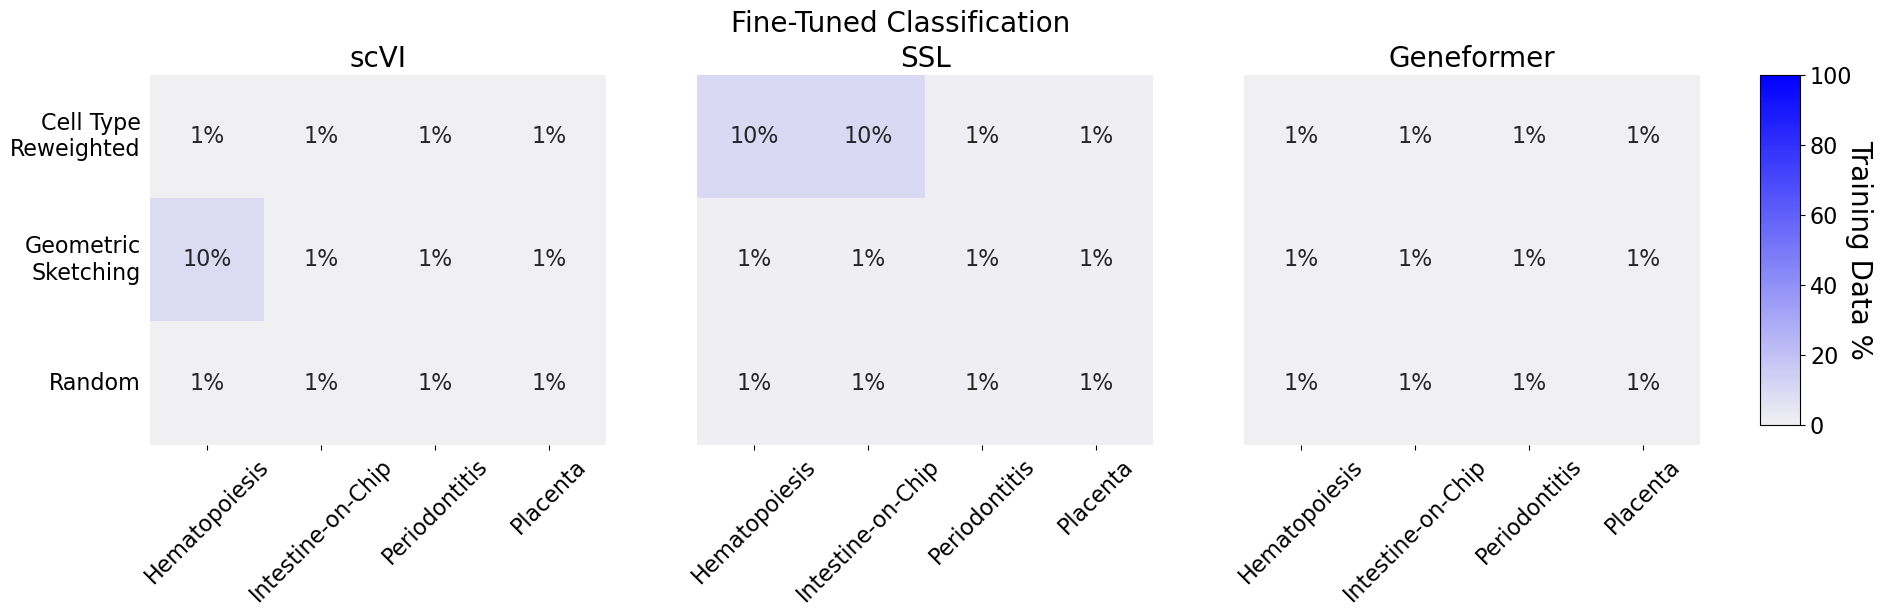

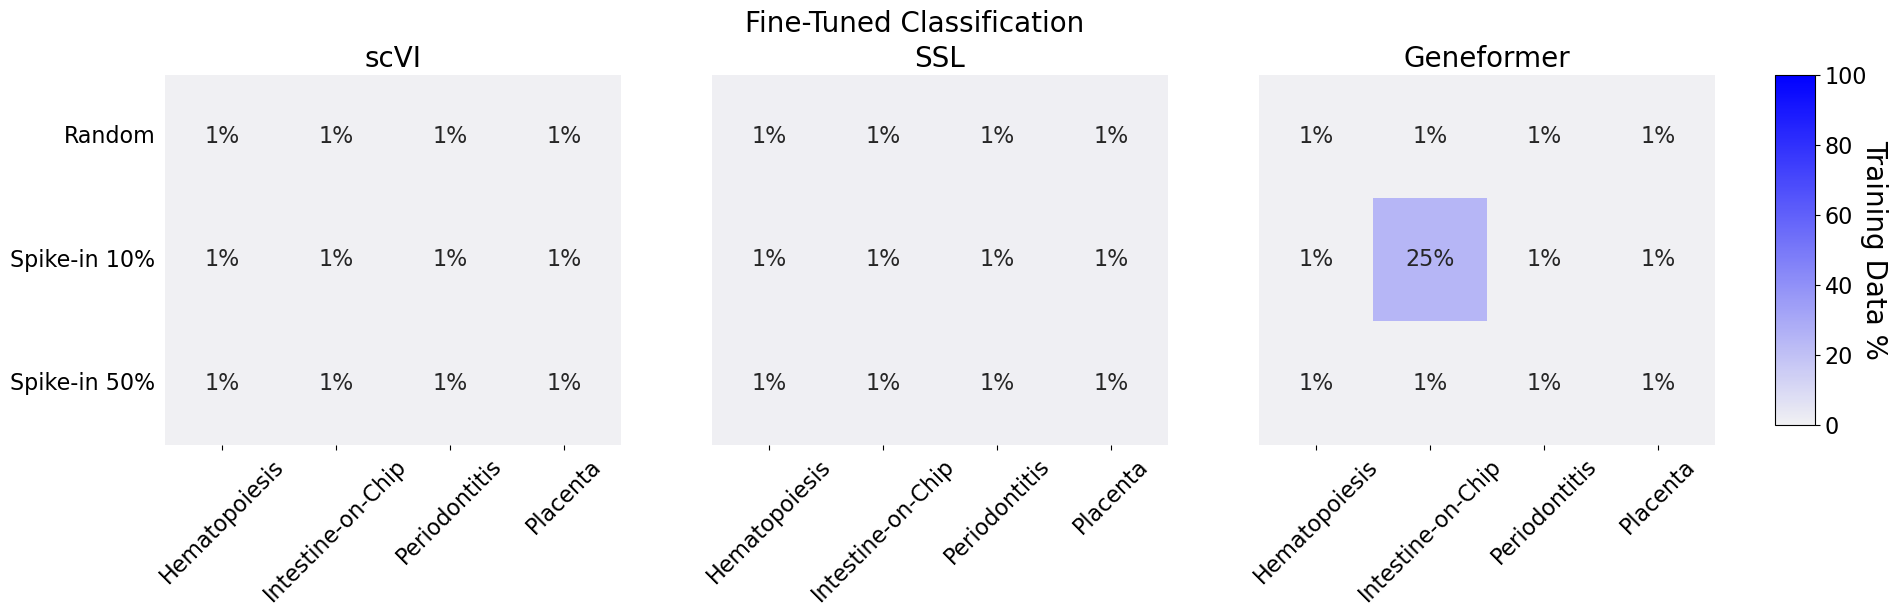

In [3]:
# fine tune classification
gf_finetune_df = pd.read_csv("metrics_csvs/Geneformer_finetune_classification_eval_results.csv", index_col=0)
ssl_finetune_df = pd.read_csv("metrics_csvs/SSL_finetune_classification_eval_results.csv", index_col=0)
scvi_finetune_df = pd.read_csv("metrics_csvs/scvi_finetune_classification_eval_results.csv", index_col=0)

metrics_dfs = [scvi_finetune_df, ssl_finetune_df, gf_finetune_df]
model_names = ["scVI", "SSL", "Geneformer"]

# alphabetical order because that is what pandas does by default
dataset_names = ["hematopoiesis", "intestine", "periodontitis", "placenta"]
dataset_formatted_names = ["Hematopoiesis", "Intestine-on-Chip", "Periodontitis", "Placenta"]

plot_title = "Fine-Tuned Classification"

evaluation = "fine_tune_classification"

include_downsampling_schemes = True
include_spikeins = False

plot_heatmap(metrics_dfs, model_names, evaluation, "micro_f1", dataset_names, dataset_formatted_names, plot_title, include_downsampling_schemes, include_spikeins)


include_downsampling_schemes = False
include_spikeins = True

plot_heatmap(metrics_dfs, model_names, evaluation, "micro_f1", dataset_names, dataset_formatted_names, plot_title, include_downsampling_schemes, include_spikeins)

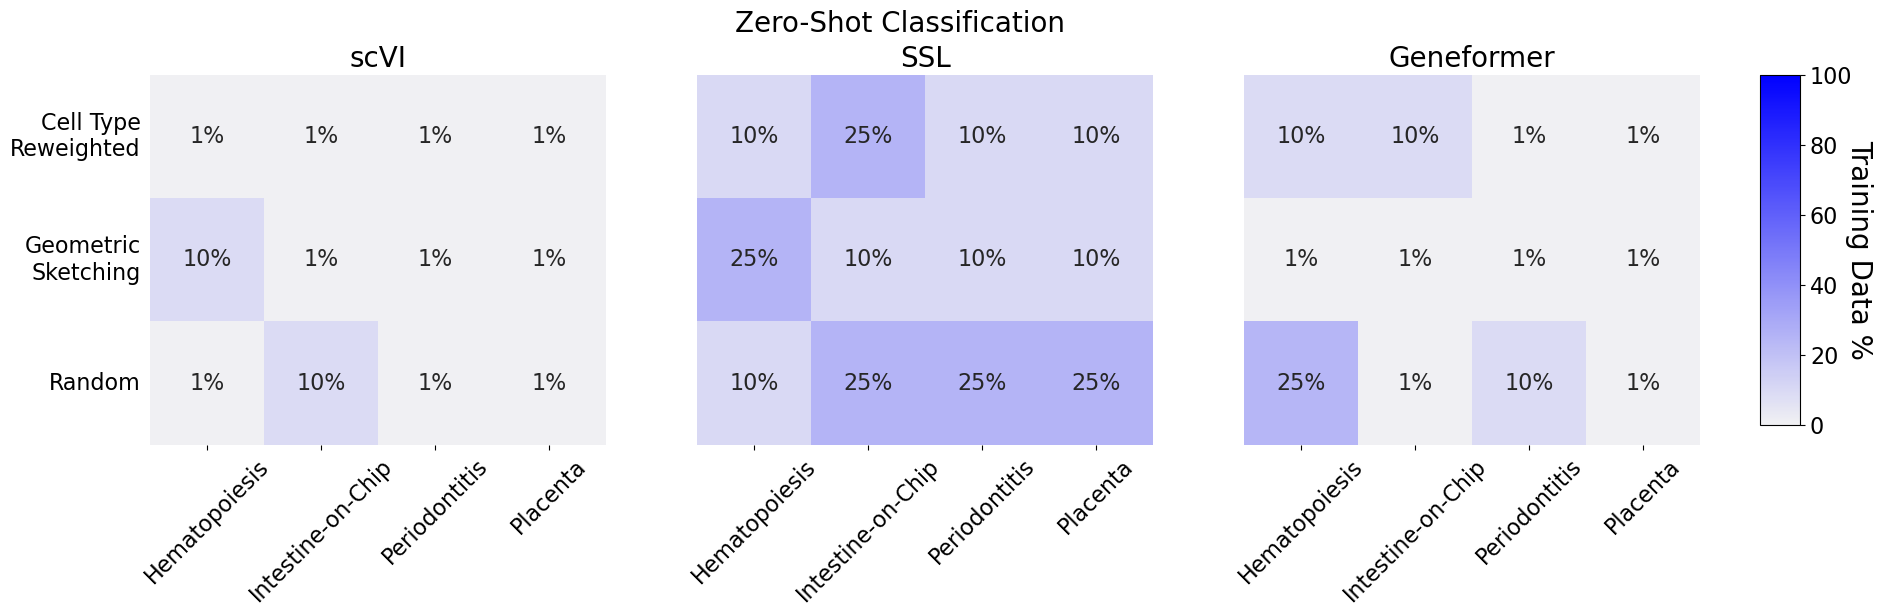

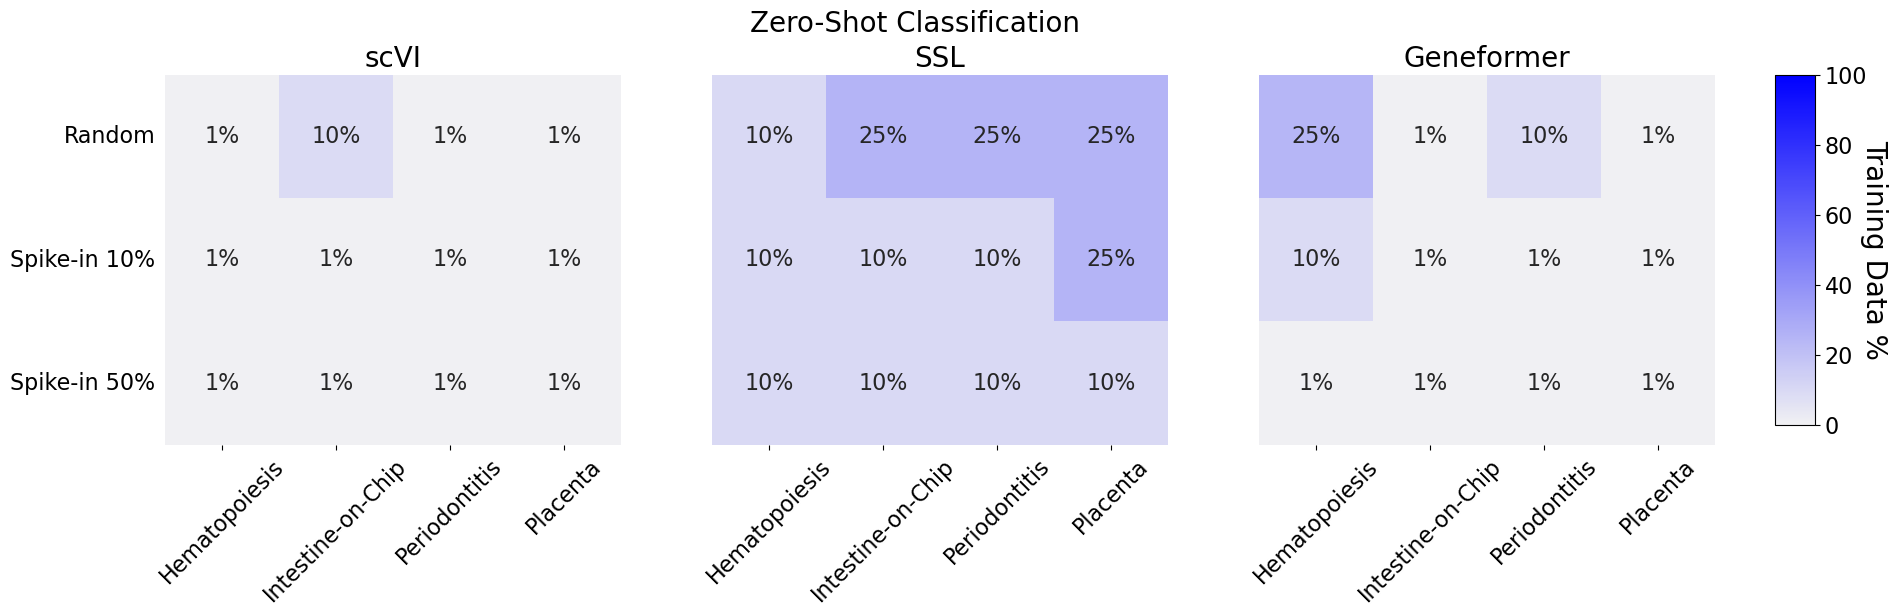

In [4]:
# zero-shot classification

gf_zeroshot_classification_df = pd.read_csv("metrics_csvs/Geneformer_zeroshot_classification_eval_results.csv", index_col=0)
ssl_zeroshot_classification_df = pd.read_csv("metrics_csvs/SSL_zeroshot_classification_eval_results.csv", index_col=0)
scvi_zeroshot_classification_df = pd.read_csv("metrics_csvs/scVI_zeroshot_classification_eval_results.csv", index_col=0)

metrics_dfs = [scvi_zeroshot_classification_df, ssl_zeroshot_classification_df, gf_zeroshot_classification_df]


# alphabetical order because that is what pandas does by default
dataset_names = ["hematopoiesis", "intestine", "periodontitis", "placenta"]
dataset_formatted_names = ["Hematopoiesis", "Intestine-on-Chip", "Periodontitis", "Placenta"]

plot_title = "Zero-Shot Classification"

evaluation = "zero_shot_classification"

include_downsampling_schemes = True
include_spikeins = False

plot_heatmap(metrics_dfs, model_names, evaluation, "micro_f1", dataset_names, dataset_formatted_names, plot_title, include_downsampling_schemes, include_spikeins)


include_downsampling_schemes = False
include_spikeins = True

plot_heatmap(metrics_dfs, model_names, evaluation, "micro_f1", dataset_names, dataset_formatted_names, plot_title, include_downsampling_schemes, include_spikeins)

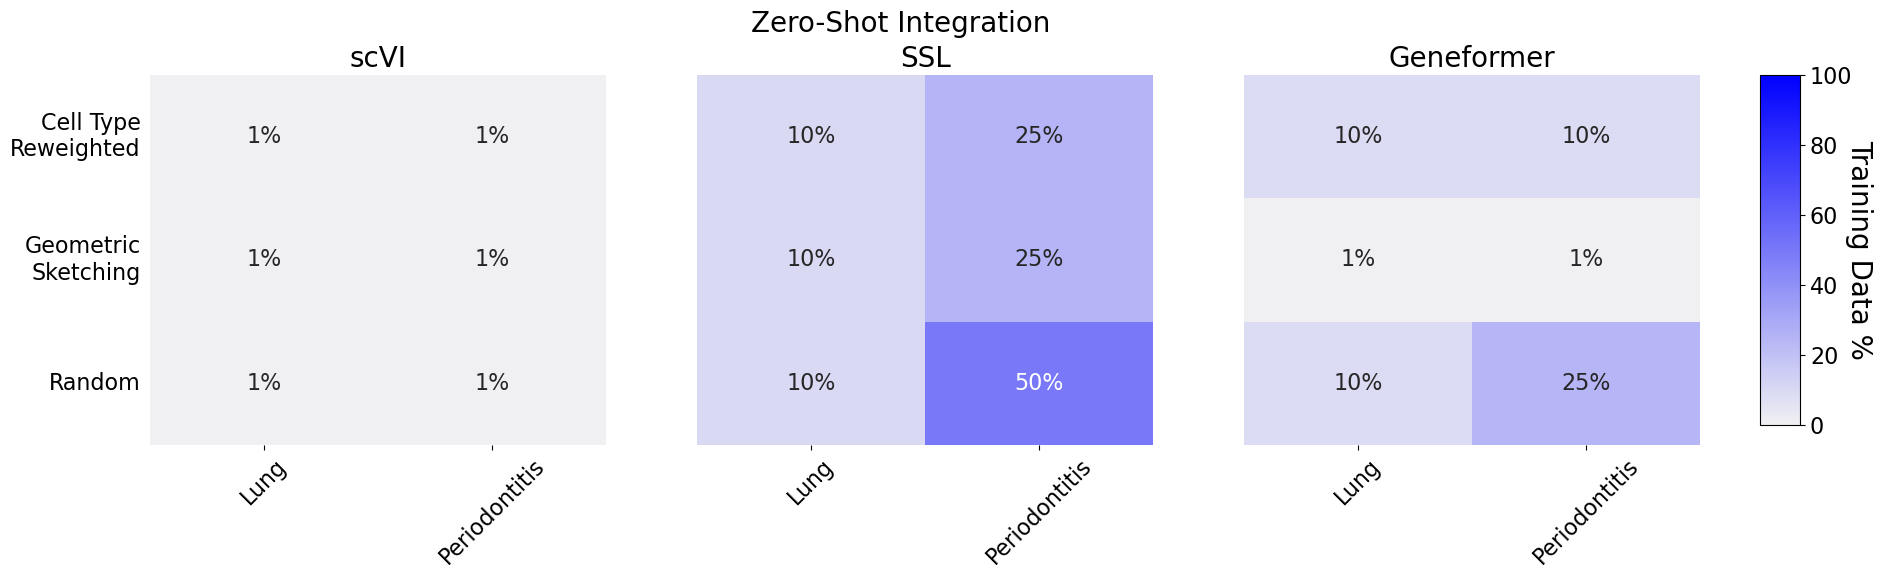

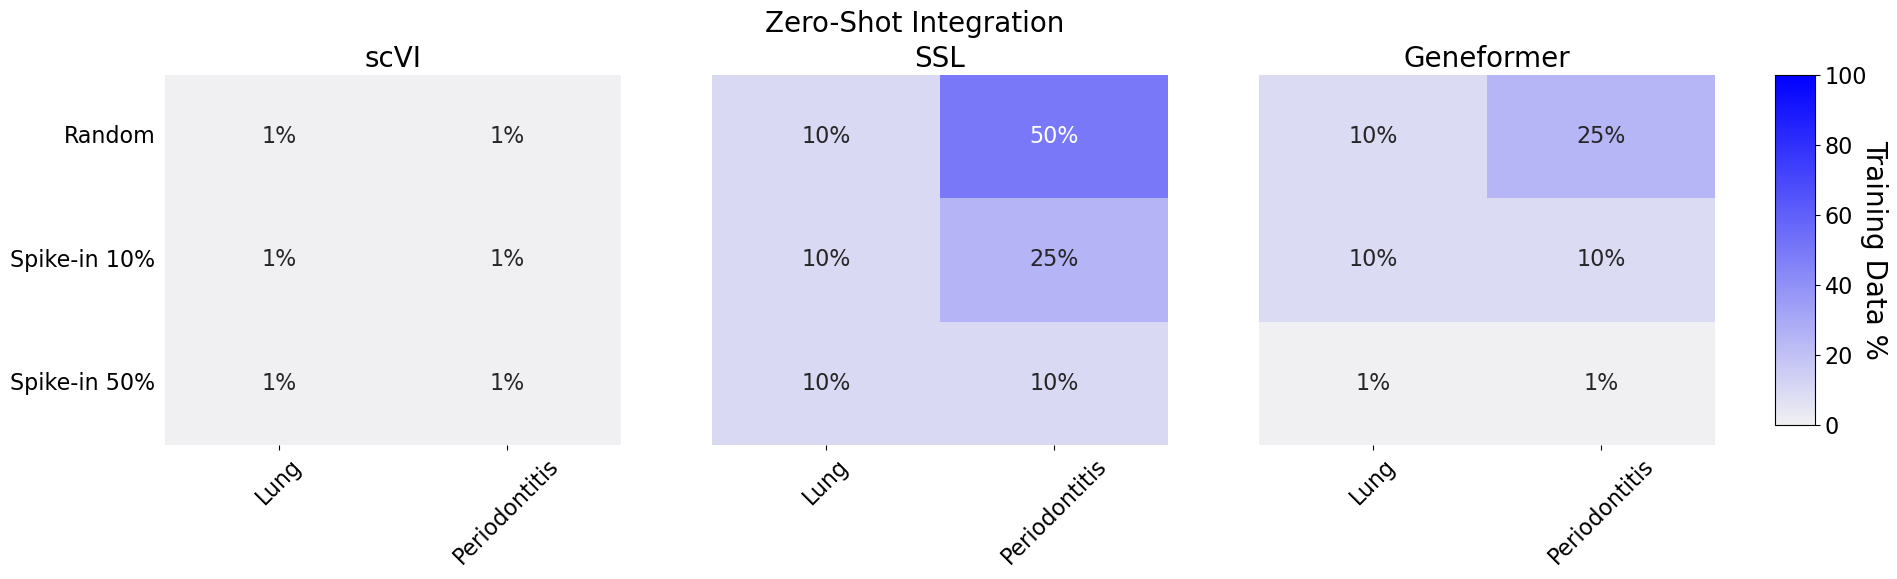

In [5]:
# zero-shot integration

gf_zeroshot_integration_df = pd.read_csv("metrics_csvs/Geneformer_zeroshot_integration_eval_results.csv", index_col=0)
scvi_zeroshot_integration_df = pd.read_csv("metrics_csvs/scVI_zeroshot_integration_eval_results.csv", index_col=0)
ssl_zeroshot_integration_df = pd.read_csv("metrics_csvs/SSL_zeroshot_integration_eval_results.csv", index_col=0)

metrics_dfs = [scvi_zeroshot_integration_df, ssl_zeroshot_integration_df, gf_zeroshot_integration_df]

# alphabetical order because that is what pandas does by default
dataset_names = ["kim_lung", "periodontitis"]
dataset_formatted_names = ['Lung', 'Periodontitis']

plot_title = "Zero-Shot Integration"
evaluation = "zero_shot_integration"

include_downsampling_schemes = True
include_spikeins = False

plot_heatmap(metrics_dfs, model_names, evaluation, "avg_bio", dataset_names, dataset_formatted_names, plot_title, include_downsampling_schemes, include_spikeins)


include_downsampling_schemes = False
include_spikeins = True

plot_heatmap(metrics_dfs, model_names, evaluation, "avg_bio", dataset_names, dataset_formatted_names, plot_title, include_downsampling_schemes, include_spikeins)
